# Transfer Learning

#### Neural Network for Suggestive CAD

--------------------------------------------------------------------------------------------------------------------------------

    Import packages

In [1]:
import numpy as np
import collections
#from tensorflow.python.framework import dtypes

from os import listdir
import os
from os.path import isfile, join
import numpy as np
import cv2

import matplotlib.pylab as plt
%matplotlib inline

from __future__ import division
from __future__ import print_function

import argparse
import sys

import glob
import param
import time

#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
import IPython.display as display

import tensorflow as tf

#import pydotplus as pydot
#import graphviz



# KERAS IMPORTS
import keras
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import History 

#SKLEARN
from sklearn.metrics import classification_report

C:\Users\TempUser\Anaconda3\envs\CPU_tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
###From https://gist.github.com/ambodi/408301bc5bc07bc5afa8748513ab9477#file-dataset-py-L74

In [4]:
###Data from  https://www.kaggle.com/c/dogs-vs-cats/data

## Saving raw data to npy

#### Load data

In [16]:
#path to directory
path_train = 'raw_data/train/'
path_test = 'raw_data/test/'
path_val = 'raw_data/val/'

img_size= 100

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

#build labels and image arrays, resize image to 100*100
def read_images_in_folder(dirlist, path):
    images=[]
    labels = []
    count = 0
    for i in range(len(dirlist)):
        image_stack = []
        for img in glob.glob(path+dirlist[i]+'/*jpg'):
            count=count+1
            labels.append(dirlist[i])
            IMG = cv2.imread(img)
            #RGB to grey scale
            #IMG_2= cv2.cvtColor( IMG, cv2.COLOR_RGB2GRAY )
            #resize to 100*100
            im_resize = cv2.resize(IMG, (img_size, img_size), 3)
            images.append(im_resize)
        #np_images = np.array(image_stack)
        
    return images, labels, count

In [17]:
if __name__ == '__main__':
    dirlist_train = directory_scan(path_train)
    images_train,labels_train,count_train = read_images_in_folder(dirlist_train, path_train)
    dirlist_test = directory_scan(path_test)
    images_test,labels_test,count_test = read_images_in_folder(dirlist_test, path_test)

if __name__ == '__main__':
    dirlist_val = directory_scan(path_val)
    images_val,labels_val,count_val= read_images_in_folder(dirlist_val, path_val)

np.save('npy-color/images_val',images_val)
np.save('npy-color/labels_val',labels_val)

#save to file
np.save('npy-color/images_train',images_train)
np.save('npy-color/labels_train',labels_train)
np.save('npy-color/images_test',images_test)
np.save('npy-color/labels_test',labels_test)

print('There are '+ str(count_train) +' training images')
print('There are '+ str(count_test) +' testing images')

nb_img_train = count_train
nb_img_test = count_test

There are 15008 training images
There are 1120 testing images


#### Load NPY data

In [2]:
#LOAD TRAIN
#load images
train_images = np.load('npy-color/images_train.npy')

#load labels
train_labels = np.load('npy-color/labels_train.npy')

#LOAD TEST
#load images
test_images = np.load('npy-color/images_test.npy')


#load labels
test_labels = np.load('npy-color/labels_test.npy')

#LOAD VALIDATION
#load images
val_images = np.load('npy-color/images_val.npy')

#load labels
val_labels = np.load('npy-color/labels_val.npy')

img_size=100

bed


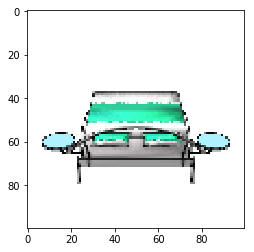

In [3]:
index = 300
print(train_labels[index])
plt.imshow(train_images[index])

In [4]:
path_train = 'raw_data/train/'
path_test = 'raw_data/test/'
path_val = 'raw_data/val/'
img_size= 100

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

dirlist_train = directory_scan(path_train)
dirlist_test = directory_scan(path_test)
dirlist_val = directory_scan(path_val)

nb_img_train = len(train_images)
nb_img_test = len(test_images)
nb_img_val = len(val_images)

In [5]:
#prepare and reshape testing/training sets
#img_size = 100
#nb_img_train = 1400
#nb_img_test = 40

train_img = train_images.reshape([-1,img_size,img_size,3])
train_img = train_img.astype('float32') / 255

test_img = test_images.reshape([-1,img_size,img_size,3])
test_img = test_img.astype('float32') / 255

val_img = val_images.reshape([-1,img_size,img_size,3])
val_img = val_img.astype('float32') / 255

#### One Hot Encoding of Labels

In [6]:
#LABEL ONE HOT ENCODING
#Training
k=0
for i in range(len(dirlist_train)):
    for j in range(len(train_labels)):
        if(train_labels[j]==dirlist_train[i]):
            train_labels[j]=k
    k=k+1

#Testing
m=0
for l in range(len(dirlist_test)):
    for h in range(len(test_labels)):
        if(test_labels[h]==dirlist_test[l]):
            test_labels[h]=m
    m=m+1
    
#Validation
g=0
for l in range(len(dirlist_val)):
    for h in range(len(val_labels)):
        if(val_labels[h]==dirlist_val[l]):
            val_labels[h]=g
    g=g+1

In [7]:
train_lab= to_categorical(train_labels)
test_lab = to_categorical(test_labels)
val_lab = to_categorical(val_labels)

In [8]:
def Plot_accuracy(train_acc, Title):
    x = [i for i in range(0, len(train_acc))]
    y= train_acc
    plt.plot(x,y)
    plt.ylabel('Accuracy')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=1)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()
    
def Plot_Loss(train_loss, Title):
    x = [i for i in range(0, len(train_loss))]
    y= train_loss
    plt.plot(x,y)
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=2)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()

--------------------------------------------------------------------------------------------------------------------------------

## Transfer Learning

https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

    Import VGG pretrained network

In [9]:
from keras import applications

In [10]:
conv_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [11]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

    Preprocess dataset with VGG model

In [26]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

train_features = conv_base.predict(train_img)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

In [29]:
#Save feature maps to file
np.save('train_features/', train_features)

In [30]:
#reshape feature maps to match output of VGG model with input of additional layers
train_features_reshaped = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

In [36]:
#Save feature maps to file
np.save('train_features/train_features', train_features_reshaped)

In [39]:
#loads feature map from file
train_features_ = np.load('train_features/train_features.npy')

In [ ]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

val_features = conv_base.predict(val_img)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

In [ ]:
val_features = np.reshape(val_features, (len(val_img), 3 * 3 * 512))

    Additional network

In [83]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(dirlist_train), activation='softmax'))

In [85]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
history = model.fit(train_features_,
                    train_lab,
                    epochs=50,
                    batch_size=500,
                    validation_data=(val_features,val_lab))

Train on 15008 samples, validate on 1120 samples
Epoch 1/50
15008/15008 [==============================] - 2s 126us/step - loss: 0.2572 - acc: 0.9152 - val_loss: 0.6641 - val_acc: 0.7911
Epoch 2/50
15008/15008 [==============================] - 2s 105us/step - loss: 0.2384 - acc: 0.9238 - val_loss: 0.6327 - val_acc: 0.7982
Epoch 3/50
15008/15008 [==============================] - 2s 104us/step - loss: 0.2291 - acc: 0.9274 - val_loss: 0.7205 - val_acc: 0.7750
Epoch 4/50
15008/15008 [==============================] - 2s 106us/step - loss: 0.2179 - acc: 0.9303 - val_loss: 0.7473 - val_acc: 0.7598
Epoch 5/50
15008/15008 [==============================] - 2s 107us/step - loss: 0.2119 - acc: 0.9334 - val_loss: 0.6394 - val_acc: 0.7955
Epoch 6/50
15008/15008 [==============================] - 2s 107us/step - loss: 0.2037 - acc: 0.9350 - val_loss: 0.6772 - val_acc: 0.7884
Epoch 7/50
15008/15008 [==============================] - 2s 108us/step - loss: 0.1967 - acc: 0.9378 - val_loss: 0.6016 - v

    Test

In [97]:
predictions = model.predict(val_features)

#one hot encoding
for i in range(len(predictions)):
    length = len(predictions[i])
    index = np.argmax(predictions[i])
    predictions[i][index] = 1
    for j in range(length):
        if(j != index):
            predictions[i][j] = 0

In [98]:
print(classification_report(test_lab, predictions, target_names = dirlist_train))

             precision    recall  f1-score   support

        bed       0.83      0.71      0.77       150
      bench       0.85      0.56      0.67        70
    cabinet       0.81      0.78      0.79       150
      chair       0.86      0.94      0.90       150
      couch       0.68      0.88      0.77       150
       lamp       0.81      0.79      0.80       150
      plant       0.95      0.91      0.93       150
      table       0.80      0.83      0.81       150

avg / total       0.82      0.82      0.81      1120



------------------------------------------------------------------------------------------------------------------------------

# R-CNN : Region based CNN

https://github.com/experiencor/basic-yolo-keras

https://github.com/philipperemy/yolo-9000